# The Cancer Genome Atlas (TCGA) Breast Invasive Carcinoma (BRCA) Dataset

This dataset measures the genetic and biological effect of BRCA in a cohort of 1000+ patients. 

For this project we have subset this dataset with common and unique patients across three datasets : 
 - Transcriptomcs (mRNA)
 - Epigentics (DNAm)
 - Proteomics (RPPA)

The prediction taks in this project is tumour subtype classification. It has been shown that, depending on the specific tumour subtype, outcomes for women with BRCA will vary significantly. Therefore, being able to accruately stratify by subtype is an important characterisation for this cancer and will affect the treatment course decided by the physician. 

The different subtypes present in this dataset are : 
- Luminal A (LumA)
- Luminal B (LumB)
- Basal
- HER2

Each of these modalities will capture a different aspect of the disease, thus many methods which can integrate them have become popular. 

In this short notebook, we will look at the different data types and give some information on their biological aspects. 

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from palettable import wesanderson as wes

data_dir = "./../data/TCGA-BRCA/"
mod = ["mRNA", "DNAm" , "RPPA"]

In [2]:
data = {}
for omic in mod : 
   with open(f"{data_dir}{omic}.pkl", "rb") as f:  # 'rb' = read binary
    data[omic] = pickle.load(f) 

## Transcriptomics (mRNA)

Transcriptomics looks at all RNA in a cell to see which genes are “on” and how strongly.

This gene expression dataset is a table of gene activity levels across breast cancer (BRCA) tissue samples

Numbers come from RNA sequencing; higher values mean more of that gene’s RNA was detected.

mRNA and genes should have a very similar distribution in a population, but when a person has a disease, the disease can cause a large change in a genes expression causing it to become over/under expressed. 

In [3]:
data['mRNA']["expr"].head()

,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,...,ENSG00000288611.1,ENSG00000288612.1,ENSG00000288638.1,ENSG00000288648.1,ENSG00000288657.1,ENSG00000288658.1,ENSG00000288663.1,ENSG00000288670.1,ENSG00000288674.1,ENSG00000288675.1
TCGA-E9-A228,11.220890,4.194486,10.680243,10.487409,9.448297,9.408937,10.505433,11.871306,10.985411,11.401380,...,3.308428,5.408347,2.843467,2.843467,2.843467,6.249685,5.485041,8.864766,4.498478,4.194486
TCGA-HN-A2NL,12.279388,3.347630,11.422199,10.338415,9.834559,8.123745,10.559379,10.412459,10.856693,11.637981,...,4.373216,4.732522,3.552924,2.843467,2.843467,6.432414,5.938534,8.195267,4.879134,6.307971
TCGA-OL-A5D7,11.436488,4.204181,11.338812,10.696614,11.024408,9.917112,9.852083,10.494274,10.290863,12.049691,...,3.469872,6.238882,2.843467,2.843467,2.843467,5.977719,5.808513,9.188112,4.707533,6.365531
TCGA-A2-A3KC,11.511191,5.737801,10.834398,10.931552,9.698790,9.609320,11.893211,11.046319,10.422642,11.226144,...,3.354080,5.578962,2.843467,3.561911,2.843467,4.064020,5.762593,8.621993,4.459940,5.431014
TCGA-A2-A0YI,12.431769,5.762581,10.823070,10.601755,8.992869,9.630460,11.674870,11.553497,11.183243,11.169297,...,3.506481,5.608277,2.843467,3.314332,2.843467,3.773210,5.460744,8.646323,4.210609,4.343591


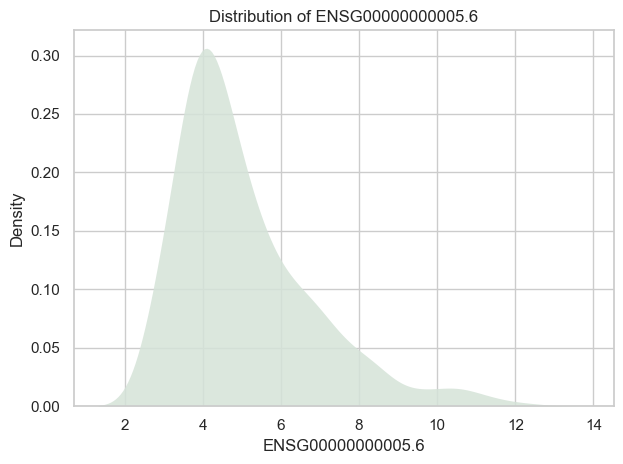

In [8]:
color = wes.Darjeeling2_5.mpl_colors[0]  # pick a color from the palette

gene = data['mRNA']["expr"].columns[1]

sns.set(style="whitegrid")
sns.kdeplot(data=data['mRNA']["expr"], x=f"{gene}", fill=True, color=color, alpha=0.85, linewidth=0)
plt.xlabel(f"{gene}")
plt.ylabel("Density"); 
plt.title(f"Distribution of {gene}")
plt.tight_layout()
plt.show()

## Epigentics (DNAm)

Epigenetics studies chemical tags on DNA sites that control gene activity without changing the DNA sequence.

DNA methylation is one such tag (adding methyl groups), referred to as CpGs,  that often reduces gene activity.

A DNA methylation dataset measures how much methylation is present at many genomic sites across samples.

These tags are crucial in aging for example, to stop us growing taller and taller indefinitely.

DNAm is a very useful measure for how we interact with out environment as the number and location of specific chemical tags can tell us if and how much someone consumes alcohol, smokes, works with pesticides, exposure to carcinogenics etc...  

In [6]:
data['DNAm']["expr"].head()

,cg11738485,cg01893212,cg21885317,cg12466610,cg15690342,cg22473620,cg02467990,cg23179456,cg04131969,cg22831607,...,cg00592510,cg06459913,cg01749500,cg17985854,cg16023912,cg03407594,cg07290865,cg06153893,cg10262891,cg07132590
TCGA-E9-A228,0.960700,0.644724,0.964877,0.589824,0.663511,0.649849,0.647587,0.693198,0.352195,0.726499,...,0.144670,0.758155,0.756128,0.684074,0.753583,0.695458,0.886056,0.728452,0.822799,0.788491
TCGA-HN-A2NL,0.583237,0.023547,0.966170,0.058889,0.073499,0.056420,0.020411,0.843894,0.026822,0.024529,...,0.095880,0.940490,0.817412,0.744143,0.891167,0.734321,0.852952,0.281028,0.422452,0.964047
TCGA-OL-A5D7,0.021655,0.035954,0.979647,0.828104,0.124674,0.072108,0.031360,0.025608,0.927734,0.731654,...,0.080530,0.945476,0.681666,0.447804,0.832570,0.843092,0.911593,0.045209,0.614898,0.951736
TCGA-A2-A3KC,0.031399,0.472174,0.613586,0.579223,0.709417,0.655372,0.410265,0.658779,0.925193,0.583415,...,0.291444,0.904078,0.618604,0.366992,0.781996,0.700943,0.868345,0.098596,0.664794,0.953521
TCGA-A2-A0YI,0.491925,0.544880,0.640366,0.592854,0.845361,0.639998,0.445780,0.555931,0.506736,0.675618,...,0.084366,0.930467,0.641724,0.589872,0.695018,0.746382,0.907000,0.028049,0.753637,0.964383


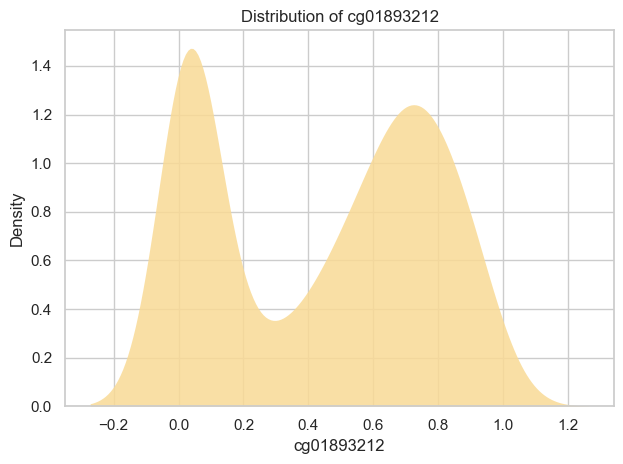

In [7]:
color = wes.Darjeeling2_5.mpl_colors[2]  # pick a color from the palette

cpg = data['DNAm']["expr"].columns[1]

sns.set(style="whitegrid")
sns.kdeplot(data=data['DNAm']["expr"], x=f"{cpg}", fill=True, color=color, alpha=0.85, linewidth=0)
plt.xlabel(f"{cpg}")
plt.ylabel("Density"); 
plt.title(f"Distribution of {cpg}")
plt.tight_layout()
plt.show()

## Proteomics (RPPA)

Proteomics studies all the proteins in a cell or tissue—what’s there and how much.

The proteomics dataset we are using is Reverse Phase Protein Array (RPPA). This dataset is a table of protein abundance levels across the tumour tissue samples.

It is measure by microscope technologies by tagging proteins in the samples with a chemical dye and quantifying how much of each protein is present by their illuminaiton. 

Proteomics is really useful to get an accurate pin-point snapshop of the biology of the tumour in its measured state. The downside is that protein measurements are sparse across patient samples with many missing samples as not every protein will be abundant in each patient. How you handle this artefact will be an important consideration in your analyses and could effect different models differently. 

In [7]:
data['RPPA']["expr"].head()

,1433BETA,1433EPSILON,1433ZETA,4EBP1,4EBP1_pS65,4EBP1_pT37T46,4EBP1_pT70,53BP1,ACC_pS79,ACC1,...,XPF,XRCC1,YAP,YAP_pS127,YB1,YB1_pS102,YTHDF2,YTHDF3,ZAP-70,ZEB1
TCGA-E9-A228,-0.011293,-0.060878,-0.202675,1.35820,0.020965,0.312617,0.102329,0.204165,0.604385,0.32035,...,0.231692,0.020158,-0.342985,-0.776035,0.057015,-0.340385,-0.099780,0.110625,-0.697522,0.226013
TCGA-HN-A2NL,0.252110,0.080503,0.197350,-0.29719,-0.374150,0.463070,-0.407030,-0.941850,0.765260,0.47086,...,0.579617,-0.424650,0.331740,0.371280,-0.220320,0.131920,-0.752445,-1.048190,0.480243,0.760178
TCGA-OL-A5D7,-0.014454,0.026866,-0.334580,0.67399,-0.605530,-0.491210,-0.009052,-0.384940,-0.186570,-0.56132,...,0.100363,0.100020,-0.020238,-0.605830,-0.676840,-0.154990,0.508370,-0.157935,2.031538,0.245044
TCGA-A2-A3KC,0.106510,0.241750,0.303230,-0.28122,-0.586760,-0.853800,-0.406400,-0.079820,0.155410,0.14472,...,-0.038458,0.101470,-0.074459,0.048927,-0.382870,-0.273140,-0.599380,-0.461275,0.632358,0.339843
TCGA-A2-A0YI,0.008400,0.101940,0.379810,-0.45383,-0.438570,-0.091300,-0.181230,0.489960,0.822000,0.58515,...,1.028037,0.167430,-0.351550,-0.286540,-0.432520,-0.194490,-0.290635,-0.340180,0.842933,0.077968


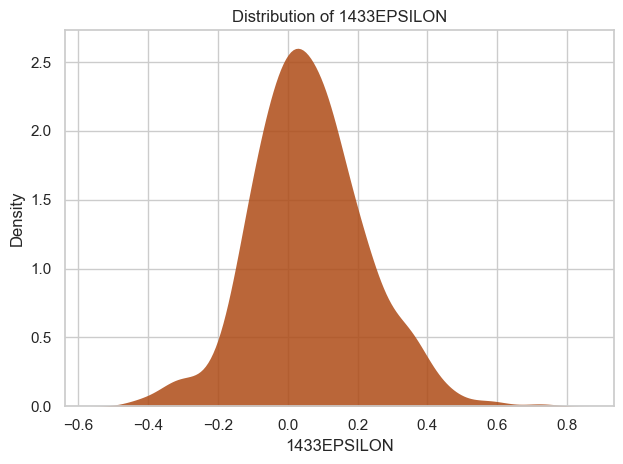

In [8]:
color = wes.Darjeeling2_5.mpl_colors[3]  # pick a color from the palette

prtn = data['RPPA']["expr"].columns[1]

sns.set(style="whitegrid")
sns.kdeplot(data=data['RPPA']["expr"], x=f"{prtn}", fill=True, color=color, alpha=0.85, linewidth=0)
plt.xlabel(f"{prtn}")
plt.ylabel("Density"); 
plt.title(f"Distribution of {prtn}")
plt.tight_layout()
plt.show()

## Next Steps 

1. Data Exploration Analysis (DEA)
   - How many patients are common to each omic, pairs of omics, and across all omics?
   - Missingness in each omic?
     - Methods of imputation?
   - Patient outliers?
     
2. MOFA

3. IntegrAO

4. PNet